## Summarising data across repeated runs of same workload 

In [1]:
import json
import pickle
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# GLOBAL VARIABLES / PARAMETERS
WORKLOAD = "WITH_ISTIO_WITHOUT_WORKLOAD"
TRACE_LOGS = f"{WORKLOAD}/"
PARSED_OUTPUTS = f"parsedOutputs/{WORKLOAD}"
NUM_RUNS = 3
FUNC_BLACKLIST = {"BLANK", "do_syscall_64()"}

#### Identifying most important functions by count

In [3]:

def get_runs():
    runs = []
    for run_data in os.listdir(PARSED_OUTPUTS):
        with open(os.path.join(PARSED_OUTPUTS, run_data), "r") as fd:
            data = json.load(fd)
            runs.append(data)
    return runs


Sample JSON
```json
"2016654": [
    {
      "function_name": "do_syscall_64() ",
      "time": 100134.8,
      "children": [
        {
          "function_name": "__x64_sys_epoll_wait() ",
          "time": 100129.9,
          "children": [
            {
              "function_name": "do_epoll_wait() ",
              "time": 100129.6,
              "children": [
                {
                  "function_name": "__fdget() ",
                  "time": 0.862,
                  "children": [
                    {
                      "function_name": "__fget_light();",
                      "time": 0.561,
                      "children": []
                    }
                  ]
                }
```

In [4]:
def get_function_counts(run, recurse=False):
    count = {}

    def get_counts(function, count, recurse):
        func_name = function["function_name"].strip().strip(";")
        if func_name not in FUNC_BLACKLIST:
            count[func_name] = count.get(func_name, 0) + 1
        if recurse:
            for child in function["children"]:
                get_counts(child, count, recurse)
    for pid in run:
        for function in run[pid]:
            get_counts(function, count, recurse)
        
    return count

def plot_counts(count, title=WORKLOAD, maxnum=20):
    maxnum = min(maxnum, len(count))
    x = sorted(list(count.keys()), key=lambda x: count[x], reverse=True)[ :maxnum]
    y = [count[_] for _ in x]


    plt.figure(figsize=(10, 4))
    plt.xticks(np.arange(len(x)), x, rotation=90)
    plt.title(title)
    plt.bar(x, y)
    plt.show()
    del x, y

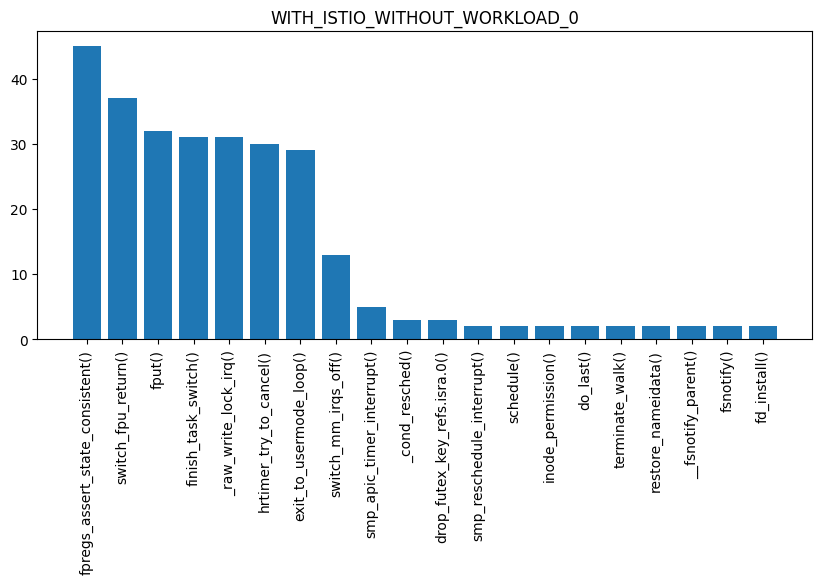

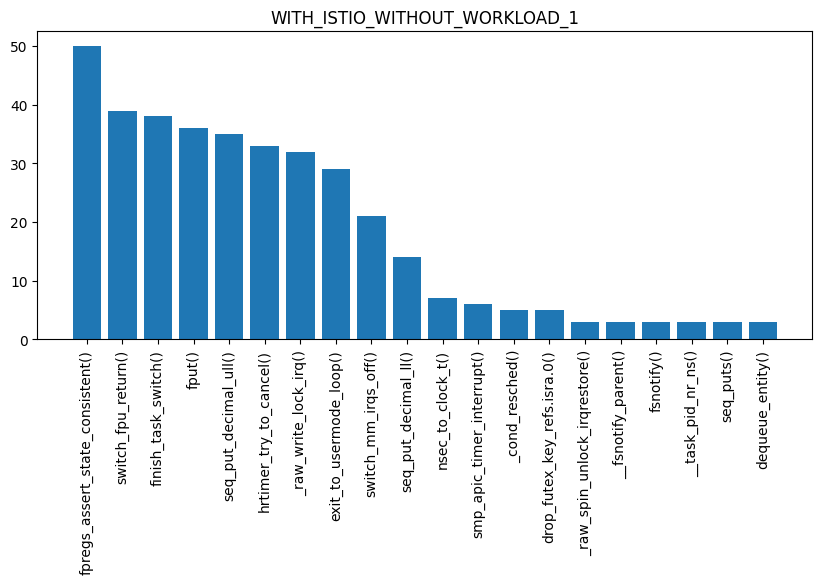

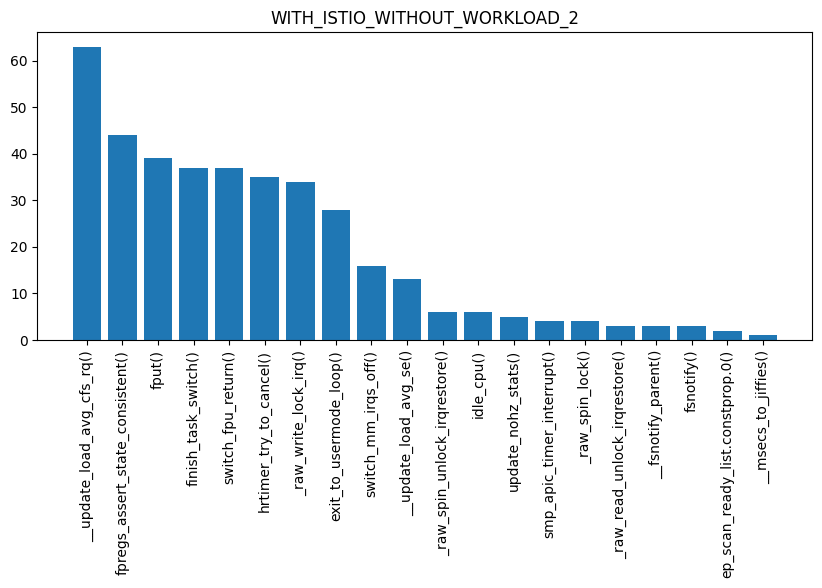

In [5]:
runs = get_runs()
for i in range(NUM_RUNS):
    count = get_function_counts(runs[i])
    plot_counts(count, title=f"{WORKLOAD}_{i}")

Points of Note
* switch_mm_irqs_off() is the most called function call consistenctly
* The function call counts are identical across the runs
* There are a total of only around 10-13 functions called in the idle runs at the top level of the callgraph

#### Parsing the callgraph recursively

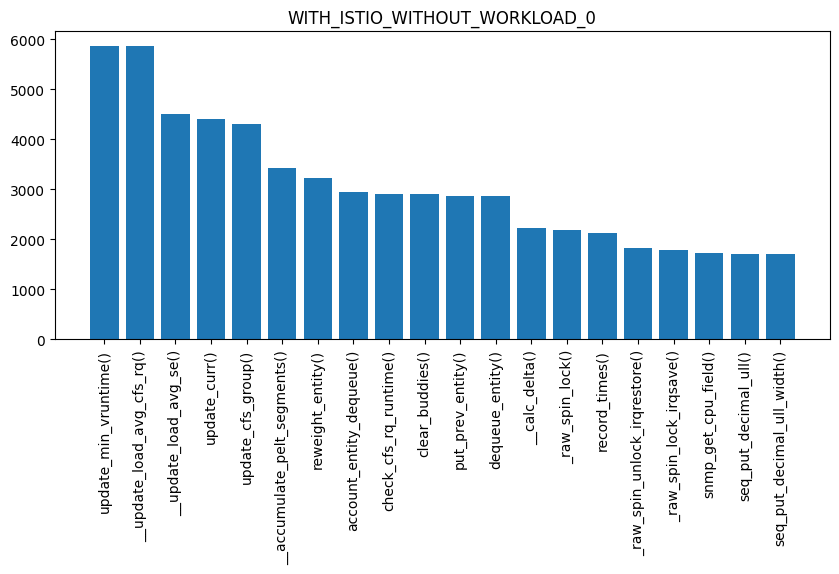

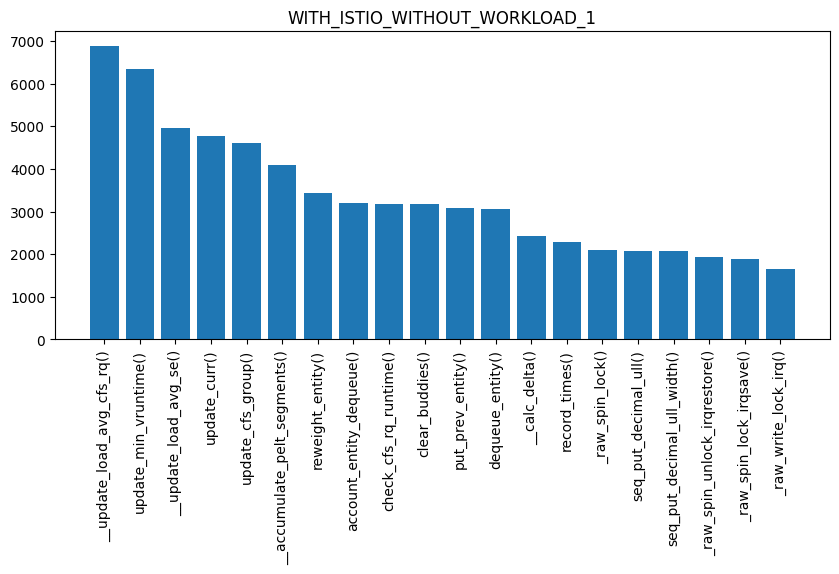

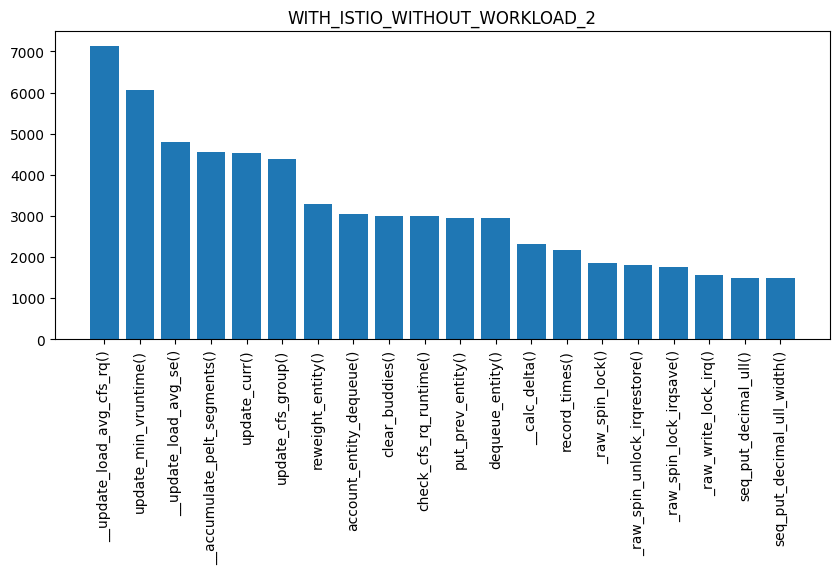

In [6]:
for i in range(NUM_RUNS):
    count = get_function_counts(runs[i], recurse=True)
    plot_counts(count, title=f"{WORKLOAD}_{i}")

In [7]:
function_counts = [get_function_counts(run, recurse=True) for run in runs]

with open(f"pickles/function_counts/{WORKLOAD}.pickle", "wb") as f:
    pickle.dump(function_counts, file=f)

In [8]:
print(len(function_counts[0]), len(function_counts[1]), len(function_counts[2]))

1121 672 702


In [9]:
for i in range(NUM_RUNS):
    for j in range(NUM_RUNS):
        if i == j:
            continue

        print(f"Calls in {i} but not in {j} ", 
            set(function_counts[i].keys()).difference(set(function_counts[j].keys())), sep="\n", end="\n")
        print()

Calls in 0 but not in 1 
{'bit_waitqueue()', 'apparmor_socket_bind()', '__dev_xdp_query()', '__mod_lruvec_state()', 'integrity_inode_free()', 'udp_queue_rcv_skb()', 'copy_msghdr_from_user()', '__nf_conntrack_hash_insert [nf_conntrack]()', 'devlink_compat_phys_port_name_get()', 'udp_destroy_sock()', 'skb_ensure_writable()', 'nf_ct_invert_tuple [nf_conntrack]()', 'mark_page_accessed()', '__udp_enqueue_schedule_skb()', '__skb_try_recv_from_queue()', 'apparmor_inode_getattr()', 'xt_dnat_target_v2 [xt_nat]()', 'inet6_fill_ifaddr()', 'security_inode_free()', 'inode_wait_for_writeback()', 'rpfilter_lookup_reverse [ipt_rpfilter]()', 'generic_file_read_iter()', 'nf_ct_del_from_dying_or_unconfirmed_list [nf_conntrack]()', 'lock_sock_fast()', 'netlink_skb_set_owner_r()', 'hash_by_src [nf_nat]()', '__x64_sys_epoll_ctl()', '__sk_free()', 'in_dev_dump_addr.isra.0()', 'vfs_getattr()', 'sock_alloc_send_skb()', '__x64_sys_recvmsg()', 'comment_mt [xt_comment]()', 'security_socket_getsockname()', '__udp_

In [10]:
def get_count_diff(function_counts):
    count_diff = {}
    for i in range(NUM_RUNS):
        for j in range(NUM_RUNS):
            if i==j:
                continue
            count_diff[f"{i}-{j}"]= {}
            for function in function_counts[i].keys():
                lhs = function_counts[i].get(function, 0) 
                rhs = function_counts[j].get(function, 0)
                if lhs <= rhs: 
                    continue
                count_diff[f"{i}-{j}"][function] = (lhs - rhs) / lhs * 100
    return count_diff


In [11]:
diff_count = get_count_diff(function_counts=function_counts)

In [12]:
[(x, diff_count["0-1"][x]) for x in sorted(diff_count["0-1"], key=lambda x: diff_count["0-1"][x], reverse=True)]

[('__mmdrop()', 100.0),
 ('pgd_free()', 100.0),
 ('free_pages()', 100.0),
 ('free_pages.part.0()', 100.0),
 ('__free_pages()', 100.0),
 ('__free_pages_ok()', 100.0),
 ('__memcg_kmem_uncharge()', 100.0),
 ('__memcg_kmem_uncharge_memcg()', 100.0),
 ('page_counter_uncharge()', 100.0),
 ('page_counter_cancel()', 100.0),
 ('propagate_protected_usage()', 100.0),
 ('kernel_poison_pages()', 100.0),
 ('free_one_page()', 100.0),
 ('__mod_zone_page_state()', 100.0),
 ('destroy_context_ldt()', 100.0),
 ('do_signal()', 100.0),
 ('get_signal()', 100.0),
 ('uprobe_deny_signal()', 100.0),
 ('dequeue_signal()', 100.0),
 ('__dequeue_signal()', 100.0),
 ('__sigqueue_free.part.0()', 100.0),
 ('free_uid()', 100.0),
 ('recalc_sigpending()', 100.0),
 ('recalc_sigpending_tsk()', 100.0),
 ('get_sigframe.isra.0.constprop.0()', 100.0),
 ('fpu__alloc_mathframe()', 100.0),
 ('copy_fpstate_to_sigframe()', 100.0),
 ('copy_siginfo_to_user()', 100.0),
 ('setup_sigcontext()', 100.0),
 ('fpu__clear()', 100.0),
 ('fpu__d

In [13]:
[(x, diff_count["0-2"][x]) for x in sorted(diff_count["0-2"], key=lambda x: diff_count["0-2"][x], reverse=True)]

[('smp_reschedule_interrupt()', 100.0),
 ('scheduler_ipi()', 100.0),
 ('tick_do_update_jiffies64.part.0()', 100.0),
 ('pipe_write()', 100.0),
 ('kill_fasync()', 100.0),
 ('__sb_start_write()', 100.0),
 ('file_update_time()', 100.0),
 ('current_time()', 100.0),
 ('ktime_get_coarse_real_ts64()', 100.0),
 ('timestamp_truncate()', 100.0),
 ('__mnt_want_write_file()', 100.0),
 ('__mnt_want_write()', 100.0),
 ('generic_update_time()', 100.0),
 ('__mark_inode_dirty()', 100.0),
 ('__mnt_drop_write_file()', 100.0),
 ('__sb_end_write()', 100.0),
 ('hrtimer_reprogram()', 100.0),
 ('do_signal()', 100.0),
 ('get_signal()', 100.0),
 ('uprobe_deny_signal()', 100.0),
 ('dequeue_signal()', 100.0),
 ('__dequeue_signal()', 100.0),
 ('__sigqueue_free.part.0()', 100.0),
 ('free_uid()', 100.0),
 ('recalc_sigpending()', 100.0),
 ('recalc_sigpending_tsk()', 100.0),
 ('get_sigframe.isra.0.constprop.0()', 100.0),
 ('fpu__alloc_mathframe()', 100.0),
 ('copy_fpstate_to_sigframe()', 100.0),
 ('copy_siginfo_to_user

In [14]:
[(x, diff_count["1-0"][x]) for x in sorted(diff_count["1-0"], key=lambda x: diff_count["1-0"][x], reverse=True)]

[('process_timeout()', 100.0),
 ('delayed_work_timer_fn()', 100.0),
 ('__queue_work()', 100.0),
 ('get_work_pool()', 100.0),
 ('insert_work()', 100.0),
 ('rcu_do_batch()', 100.0),
 ('rcu_segcblist_extract_done_cbs()', 100.0),
 ('rcu_cblist_dequeue()', 100.0),
 ('i_callback()', 100.0),
 ('sock_free_inode()', 100.0),
 ('file_free_rcu()', 100.0),
 ('epi_rcu_free()', 100.0),
 ('rcu_segcblist_insert_done_cbs()', 100.0),
 ('rcu_segcblist_insert_count()', 100.0),
 ('can_migrate_task()', 100.0),
 ('kthread_is_per_cpu()', 100.0),
 ('detach_entity_cfs_rq()', 100.0),
 ('propagate_entity_cfs_rq()', 100.0),
 ('attach_task()', 100.0),
 ('loopback_xmit()', 100.0),
 ('check_spread.isra.0.part.0()', 100.0),
 ('tcp_add_backlog()', 100.0),
 ('skb_condense()', 100.0),
 ('set_next_entity()', 74.46808510638297),
 ('housekeeping_cpumask()', 72.72727272727273),
 ('set_next_buddy()', 72.0),
 ('wakeup_preempt_entity.isra.0()', 66.66666666666666),
 ('call_timer_fn()', 66.66666666666666),
 ('account_user_time()',

In [15]:
[(x, diff_count["2-0"][x]) for x in sorted(diff_count["2-0"], key=lambda x: diff_count["2-0"][x], reverse=True)]

[('unix_poll()', 100.0),
 ('__x64_sys_readv()', 100.0),
 ('do_readv()', 100.0),
 ('vfs_readv()', 100.0),
 ('do_iter_read()', 100.0),
 ('do_iter_readv_writev()', 100.0),
 ('aa_unix_msg_perm()', 100.0),
 ('unix_stream_recvmsg()', 100.0),
 ('unix_stream_read_generic()', 100.0),
 ('unix_stream_read_actor()', 100.0),
 ('skb_unlink()', 100.0),
 ('unix_destruct_scm()', 100.0),
 ('unix_write_space()', 100.0),
 ('__x64_sys_writev()', 100.0),
 ('do_writev()', 100.0),
 ('vfs_writev()', 100.0),
 ('do_iter_write()', 100.0),
 ('unix_stream_sendmsg()', 100.0),
 ('wait_for_unix_gc()', 100.0),
 ('unix_scm_to_skb()', 100.0),
 ('skb_copy_datagram_from_iter()', 100.0),
 ('maybe_add_creds()', 100.0),
 ('can_migrate_task()', 100.0),
 ('kthread_is_per_cpu()', 100.0),
 ('detach_entity_cfs_rq()', 100.0),
 ('propagate_entity_cfs_rq()', 100.0),
 ('attach_task()', 100.0),
 ('sched_cfs_period_timer()', 100.0),
 ('estimation_timer [ip_vs]()', 100.0),
 ('tcp_delack_timer()', 100.0),
 ('tcp_delack_timer_handler()', 1

In [16]:
[(x, diff_count["2-1"][x]) for x in sorted(diff_count["2-1"], key=lambda x: diff_count["2-1"][x], reverse=True)]

[('unix_poll()', 100.0),
 ('__x64_sys_readv()', 100.0),
 ('do_readv()', 100.0),
 ('vfs_readv()', 100.0),
 ('rw_copy_check_uvector()', 100.0),
 ('do_iter_read()', 100.0),
 ('do_iter_readv_writev()', 100.0),
 ('aa_unix_msg_perm()', 100.0),
 ('unix_stream_recvmsg()', 100.0),
 ('unix_stream_read_generic()', 100.0),
 ('unix_stream_read_actor()', 100.0),
 ('consume_skb()', 100.0),
 ('skb_unlink()', 100.0),
 ('unix_destruct_scm()', 100.0),
 ('sock_wfree()', 100.0),
 ('unix_write_space()', 100.0),
 ('__x64_sys_writev()', 100.0),
 ('do_writev()', 100.0),
 ('vfs_writev()', 100.0),
 ('do_iter_write()', 100.0),
 ('unix_stream_sendmsg()', 100.0),
 ('wait_for_unix_gc()', 100.0),
 ('security_socket_getpeersec_dgram()', 100.0),
 ('apparmor_socket_getpeersec_dgram()', 100.0),
 ('sock_alloc_send_pskb()', 100.0),
 ('alloc_skb_with_frags()', 100.0),
 ('skb_set_owner_w()', 100.0),
 ('unix_scm_to_skb()', 100.0),
 ('skb_put()', 100.0),
 ('skb_copy_datagram_from_iter()', 100.0),
 ('maybe_add_creds()', 100.0),

In [17]:
[(x, diff_count["1-2"][x]) for x in sorted(diff_count["1-2"], key=lambda x: diff_count["1-2"][x], reverse=True)]

[('process_timeout()', 100.0),
 ('delayed_work_timer_fn()', 100.0),
 ('rcu_do_batch()', 100.0),
 ('rcu_segcblist_extract_done_cbs()', 100.0),
 ('rcu_cblist_dequeue()', 100.0),
 ('i_callback()', 100.0),
 ('sock_free_inode()', 100.0),
 ('file_free_rcu()', 100.0),
 ('epi_rcu_free()', 100.0),
 ('rcu_segcblist_insert_done_cbs()', 100.0),
 ('rcu_segcblist_insert_count()', 100.0),
 ('tick_do_update_jiffies64.part.0()', 100.0),
 ('__x64_sys_nanosleep()', 100.0),
 ('get_timespec64()', 100.0),
 ('hrtimer_nanosleep()', 100.0),
 ('do_nanosleep()', 100.0),
 ('hrtimer_reprogram()', 100.0),
 ('pipe_poll()', 100.0),
 ('pipe_read()', 100.0),
 ('generic_pipe_buf_confirm()', 100.0),
 ('anon_pipe_buf_release()', 100.0),
 ('kill_fasync()', 100.0),
 ('touch_atime()', 100.0),
 ('atime_needs_update()', 100.0),
 ('current_time()', 100.0),
 ('ktime_get_coarse_real_ts64()', 100.0),
 ('timestamp_truncate()', 100.0),
 ('__sb_start_write()', 100.0),
 ('__mnt_want_write()', 100.0),
 ('generic_update_time()', 100.0),

### Conclusion
* There is not a signifiicant difference between the counts of the various calls.
* Especially in without-istio-without-workload, most calls are seen very infrequently 
* The most frequent calls can be noted and assigned low weightage in future anlaysis